In [2]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # only needed for very old sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns




In [4]:
#  Separate features and target
X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]

In [5]:
# Load dataset
data = pd.read_csv("housing.csv")

#  Handle missing values (drop rows with NaNs for simplicity)
data.dropna(inplace=True)

In [6]:
#  Identify numerical and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

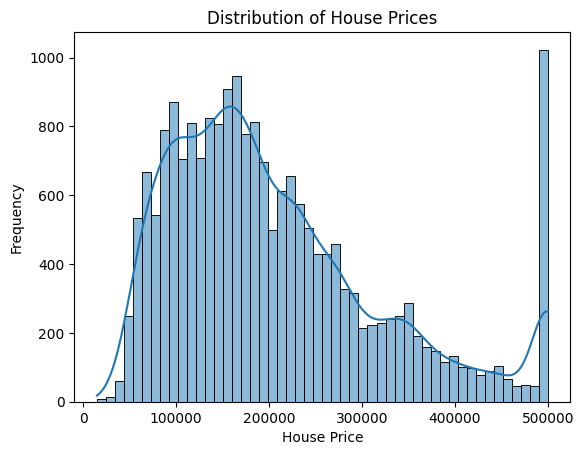

In [7]:
sns.histplot(data['median_house_value'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.show()

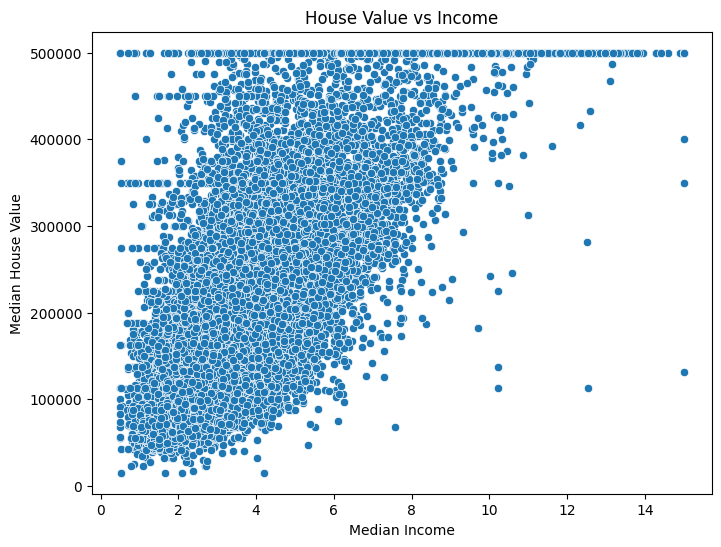

In [11]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x='median_income', y='median_house_value', data=data)
plt.title("House Value vs Income")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.show()


In [14]:
#  Define pipelines
# Numerical pipeline
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # For sklearn ≥1.2
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

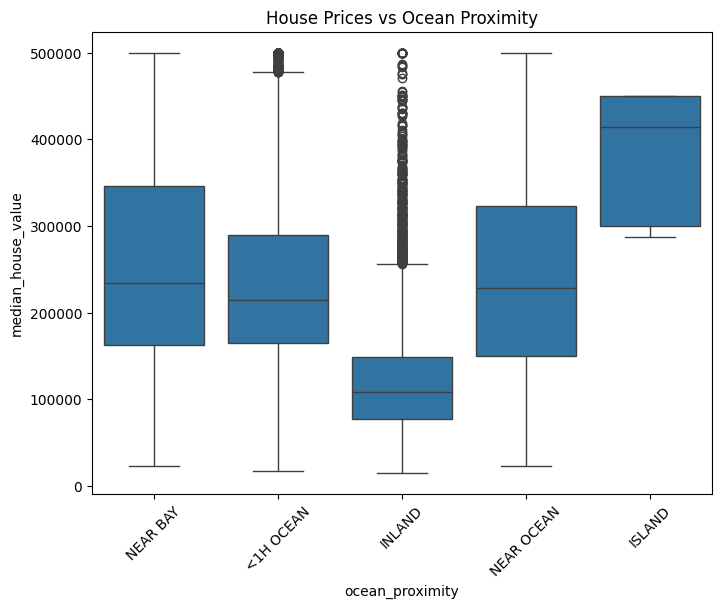

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=data)
plt.title("House Prices vs Ocean Proximity")
plt.xticks(rotation=45)
plt.show()


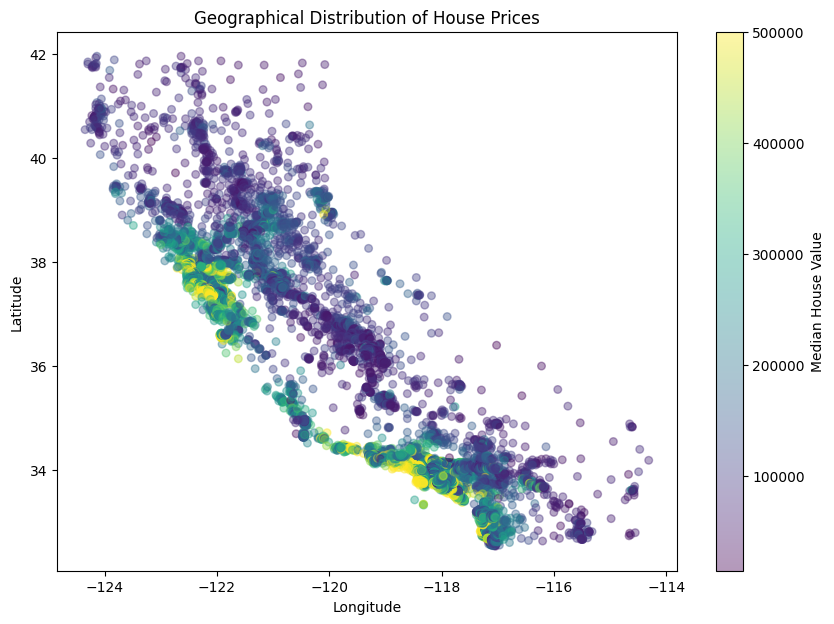

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(data['longitude'], data['latitude'], alpha=0.4,
            c=data['median_house_value'], cmap='viridis', s=30)
plt.colorbar(label='Median House Value')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of House Prices")
plt.show()


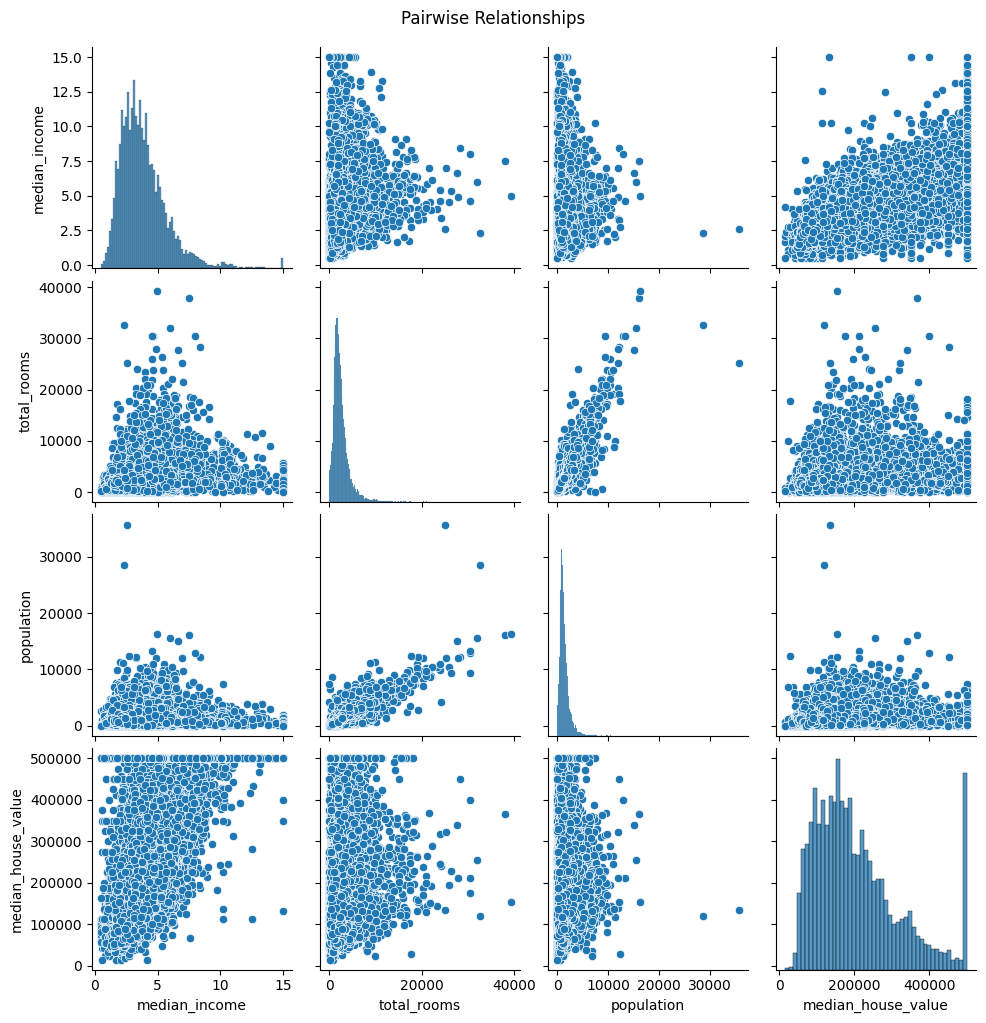

In [14]:
key_features = ['median_income', 'total_rooms', 'population', 'median_house_value']
sns.pairplot(data[key_features])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


In [15]:
# Full modeling pipeline
from sklearn.svm import SVR

model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVR())
])

param_distributions = {
    "model__C": uniform(1, 10),
    "model__epsilon": uniform(0.1, 1),
    "model__kernel": ["linear", "rbf"],
    "model__gamma": ["scale", "auto"]
}


In [8]:
#  Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

#  Define the final model pipeline with HGBR
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

#  Define hyperparameter search space
param_distributions = {
    "model__learning_rate": uniform(0.01, 0.2),
    "model__max_iter": randint(100, 300),
    "model__max_depth": randint(3, 10),
    "model__l2_regularization": uniform(0.0, 1.0)
}

In [24]:
# Randomized Search for fast tuning
search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#  Fit the model
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['longitude',
                                                                                'latitude',
                                                                                'housing_median_age',
                                                                                'total_rooms',
                                                                                'total_bedrooms',
                                                                                'population',
                                                                                'households',
                                                                                'median_income']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_...
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000013D595A2390>,
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D5957B230>,
                                        'model__max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D59579400>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [30]:
# Evaluate
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Best Parameters:", search.best_params_)
print(" RMSE on Test Set:", round(rmse, 2))

Best Parameters: {'model__l2_regularization': 0.056411579027100256, 'model__learning_rate': 0.15439975445336496, 'model__max_depth': 8, 'model__max_iter': 137}
 RMSE on Test Set: 47293.74


In [31]:
print("Min price:", y.min())
print("Max price:", y.max())
print("Mean price:", y.mean())


Min price: 14999.0
Max price: 500001.0
Mean price: 206864.41315519012


In [32]:
y_pred = best_model.predict(X_test)


In [33]:
y_pred

array([206566.91166547, 138255.10353434, 184730.88691698, ...,
        90956.35889221, 115384.6091022 , 124916.3926474 ])